# Reproduction code for the figure : comparison of two uncertainty measures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.autograd as autograd 
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs)

#### Define the network

In [2]:
def init_weights(m, mean, std):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean, std)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias, mean, std)

        
class QRContext(nn.Module):
    """
    The quantile estimator modeled by a NN.
    Initialized with respect to a normal prior (mean_prior, std_prior)
    """
    def __init__(self, num_actions, n_features, num_quants, mean_prior, std_prior, l2_reg):
        super(QRContext, self).__init__()
        self.num_actions = num_actions
        self.n_features = n_features
        self.num_quants  = num_quants
        self.mean_prior = mean_prior
        self.std_prior = std_prior
        self.l2_reg = l2_reg
        self.name = "QRDQN_epsilon"
        
        self.features = nn.Sequential(
            nn.Linear(self.n_features, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, self.num_actions * self.num_quants, bias=False))

        self.features.apply(lambda m: init_weights(m, self.mean_prior, self.std_prior))
        #self.features[0].requires_grad = False
        # Save prior 
        self.prior = [p.data.clone() for p in list(self.features.parameters())]


    def forward(self, x):
        batch_size = x.size(0)
        x = Variable(torch.FloatTensor(np.float32(x)))
        x = self.features(x)
        x = x.view(batch_size, self.num_actions, self.num_quants)
        return x
    
def create_networks(num_networks, num_actions, n_features, num_quant, mean_prior, std_prior, lr=3e-4, l2_reg=5e-3):
    current_model_list = []
    optimizer_list = []
    for b in range(num_networks):
        current_model_list.append(QRContext(num_actions=num_actions,
                                            n_features=n_features,
                                            num_quants=num_quant,
                                            mean_prior=mean_prior,
                                            std_prior=std_prior,
                                            l2_reg=l2_reg))


    for c in current_model_list:
        optimizer_list.append(optim.Adam(c.parameters(), lr=lr))

    return current_model_list, optimizer_list#### Parameters for the experiment

#### Parameters for the experiment

In [3]:
models = [] 
num_quants = range(5, 155, 5)
mean_prior = 0
std_prior = 0.2
num_networks = 20
normal = torch.distributions.normal.Normal(0,1)
train_length = 300 #Allows us to train all networks until convergence

#### Train ensembles of 20 anchored networks for different numbers of quantiles

In [4]:
ensemble_uncertainty = []
all_models = [] #Saved all trained models within the ensemble to calculate 2-network uncertainties

n_samples = 20
samples = normal.sample((n_samples,1)) #Note: all networks are trained on the same samples
X = torch.ones((n_samples, 1))

for num_quant in tqdm(num_quants):
    # Init models
    current_model_list, optimizer_list = create_networks(num_networks=num_networks,
                                                                      num_actions=1,
                                                                    n_features=1,
                                                                       num_quant=num_quant,
                                                                       mean_prior=mean_prior,
                                                                       std_prior=std_prior,
                                                                    lr = 1e-3,
                                                                            l2_reg=5)  

    
    for frame_idx in range(1, train_length):
        # Update the current models
        for n in range(num_networks):
            
            dist = current_model_list[n](X).squeeze(1) #Predicted distribution
            
            tau_hat = torch.linspace(0.0, 1.0 - 1. / num_quant, num_quant) + 0.5 / num_quant
            tau_hat = tau_hat.unsqueeze(0).repeat(n_samples, 1)
            
            u = samples - dist
            # Compute loss
            k = 1
            huber_loss = 0.5 * u.abs().clamp(min=0.0, max=k).pow(2)
            huber_loss += k * (u.abs() - u.abs().clamp(min=0.0, max=k))
            quantile_loss = (tau_hat - (u < 0).float()).abs() * huber_loss
            loss = quantile_loss.mean(0).sum()
            reg = []
            for i, p in enumerate(current_model_list[n].parameters()):
                sigma = torch.tensor([current_model_list[n].l2_reg]).repeat(p.shape[0])
                sigma = torch.diag(sigma).float()
                diff = (p - current_model_list[n].prior[i]).view(p.shape[0], -1)
                reg.append(torch.norm(torch.mm(sigma, diff), 2)**2)
            loss += torch.sum(torch.stack(reg))/n_samples
            optimizer_list[n].zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(current_model_list[n].parameters(), 0.5)
            optimizer_list[n].step() 
    
    
    #Calculate uncertainty using the ensemble
    dists = torch.stack([mod(X[0]).squeeze() for mod in current_model_list])
    ensemble_uncertainty.append((num_quant , np.sqrt(dists.var(0).mean().item()) ))  
    
    all_models.append([current_model_list[i] for i in range(num_networks)])
    

100%|██████████| 30/30 [14:58<00:00, 32.15s/it]


#### Calculate and plot all possible two-network uncertainties from the ensemble using our metric, and compare to uncertainty given by the empirical standard deviation of the 20 network ensemble

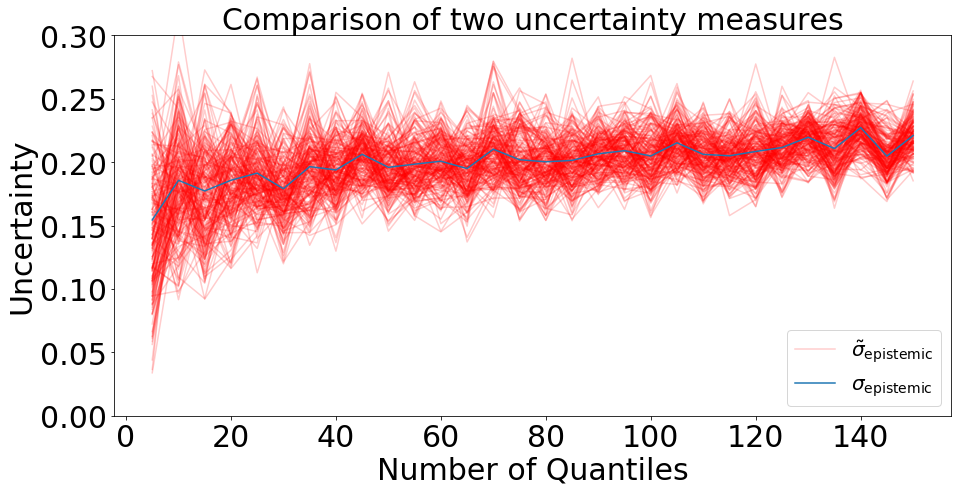

In [6]:
x1, y1 = zip(*ensemble_uncertainty)

plt.figure(figsize=(15,7))
for i in range(num_networks):
    for j in range(i):
        data=[]
        for k in range(len(all_models)):
            out0 = all_models[k][i](X[0]).squeeze()
            out1 = all_models[k][j](X[0]).squeeze()
            num_quant = out0.shape[0]
            data.append(torch.sqrt(((out0 - out1)**2).sum()/(2 * x1[k])).item())
        if (i == 1 and j == 0):
            plt.plot(x1, data, 'r', alpha=0.2, label=r'$\tilde{\sigma}_\mathrm{epistemic}$')
        else:
            plt.plot(x1, data, 'r', alpha=0.2)

plt.plot(x1, y1, label=r'$\sigma_\mathrm{epistemic}$')
plt.xlabel("Number of Quantiles", fontsize=30)
plt.ylabel("Uncertainty", fontsize=30)
plt.xticks(size=30)
plt.yticks(size=30)

plt.title('Comparison of two uncertainty measures', size=30)
plt.ylim([0,0.3])
plt.legend(prop={'size': 20}, loc=0)


#### Calculate and plot average standard deviation of the two-network uncertainties to the uncertainty by the ensemble

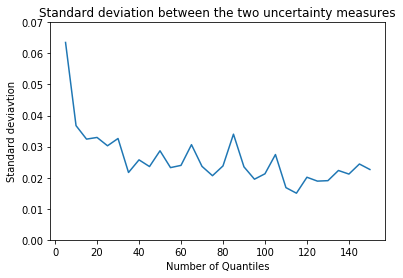

In [6]:
std = []
for k in range(len(all_models)):
    data = []
    for i in range(num_networks):
        for j in range(i):
            out0 = all_models[k][i](X[0]).squeeze()
            out1 = all_models[k][j](X[0]).squeeze()
            data.append(torch.sqrt(((out0 - out1)**2).sum()/(2 * x1[k])).item() - y1[k])
    std.append(np.std(data))

plt.ylim([0,0.07])    
plt.xlabel("Number of Quantiles")
plt.ylabel("Standard deviavtion")
plt.title('Standard deviation between the two uncertainty measures')
plt.plot(x1,std)